In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.multicomp import MultiComparison

from scipy import stats
import scipy 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

### 자료 소개

**`grid_250_all.csv`는 전주시를 250x250 나눈 후 인구와 공간적 데이터, 그리고 범죄주의구간(폭행, 절도, 성폭행) 등급의 강도로 구성되어있다.  
해당 데이터를 통해 전주시의 3대 범죄 발생에 영향을 끼치는 요인을 파악 후 범죄 위험지역에 대해 판단해 보려한다.** 

**데이터는 국가정보포털에서 격자별 인구 및 건축물에 대한 데이터를 수집하였으며, 가로등 주차장 등은 각 데이터의 좌표를 기준으로 격자내의 개수를 입력하였다.**  
**범죄주의구간은 생활안전지도의 치안사고발생현황을 바탕으로 만들어진 범죄주의구간 (1~10등급)의 지도를 이용하여 격자별 주의구간의 등급을 산정했다. (각 등급의 최대값)**  
자료는 총 43개의 변수로 구성되어 있으며, 격자는 총 918개이다. 

#### raw data
<code>gird_250</code> = 전주시 범죄관련 데이터
- <code>INDEX</code> = 인덱스
- <code>ID</code> = 각 격자의 고유 ID
- <code>총인구</code> = 격자별 총인구
- <code>고등여성인구</code> = 격자별 고등학생 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>20대여성인구</code> = 격자별 20대 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>유소년인구</code> = 격자별 유소년인구(0~14세)
- <code>고령인구</code> = 격자별 고령인구(65세 이상)
- <code>30년이상35년미만건축물</code> = 30년이상 35년미만건축물의 수 
- <code>35년이상건축물</code> = 35년이상 건축물 
- <code>개별주택가격</code> = 격자별 개별주택가격의 평균 
- <code>공시지가</code> = 격자별 평균 공시지가 
- <code>행정동코드</code> = 격자가 속한 행정동
- <code>가로등</code> = 격자별 가로등의 수 
- <code>공영주차장</code> = 격자별 공영주차장수
- <code>공중화장실</code> = 격자별 공중화장실수
- <code>교육시설</code> = 격자별 교육시설의 수 (학원, 어린이집)
- <code>대규모점포</code> = 격자별 대규모 점포의 수 (홈플러스, 이마트 등)
- <code>대부업현황</code> = 격자별 대부업체의 수
- <code>룸살롱</code> = 격자별 룸살롱의 수 
- <code>버스정류장</code> = 격자별 버스정류장의 수
- <code>보안등</code> = 격자별 보안등의 수
- <code>상가</code> = 격자별 상가의 수 (교육시설,음식점,술집,도소매업 오락시설을 포함한 상가의 수)
- <code>숙박업소</code> = 격자별 숙박업소의 수
- <code>술집</code> = 격자별 술집 (술집+룸살롱)
- <code>어린이보호</code> = 격자별 어린이보호구역의 수
- <code>어린이집</code> = 격자별 어린이집 수
- <code>오락시설</code> = 격자별 오락시설 (노래방, 당구장, pc방 등)
- <code>원룸_오피스텔</code> = 격자별 원룸 및 오피스텔의 수
- <code>음식점</code> = 격자별 음식점 수
- <code>자율방범대</code> = 격자별 자율방범대 수
- <code>파출소</code> = 격자별 파출소의 수
- <code>cctv</code> = 격자별 cctv 수
- <code>신호등</code> = 격자별 신호등의 수
- <code>횡단보도</code> = 격자별 횡단보도의 수
- <code>GRADE_전체</code> = 격자별 범죄주의등급(2~11)

In [2]:
grid_250 = pd.read_csv('/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_data.csv')

In [3]:
grid_250 = grid_250.fillna(0)

#### 파생변수 생성 및 변수 조정 
- 고등여성인구 + 20대여성인구 = 성폭력취약인구 
- 건축물(30_34)+ 건축물(35) = 30년 이상 건축물
- GRADE가 원래 1~10이나, 데이터 수집 과정에서 에러가 있어 2~11을 1로 조정 
- 필요없는 변수 제거 

In [4]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_폭력'] = grid_250['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_성폭력'] = grid_250['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_절도'] = grid_250['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)

grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

In [ ]:
grid_250[grid_250['GRADE']]

### 공시지가와, 종속변수 제외 모든 변수가 0인 행 탐색 

In [136]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row

In [137]:
print(len(grid_250),len(feat_N),len(feat_Y))

3498 1460 2038


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개

In [138]:
feat_N_ID = list(feat_N['ID'])
out = open('/Users/gimdong-wan/Desktop/out.txt','w')
print(feat_N_ID,file = out)

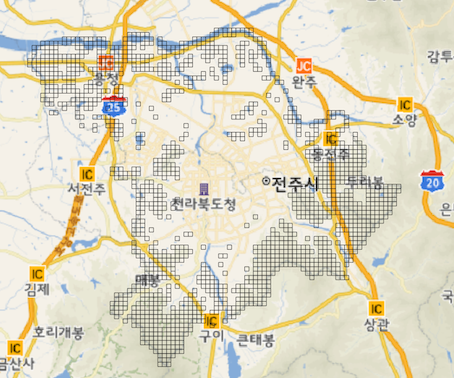

In [139]:
Image("/Users/gimdong-wan/Desktop/DataCampus/img/feat_N_grid/전체.png")

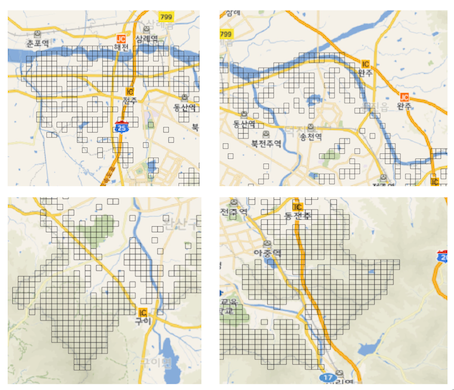

In [140]:
Image("/Users/gimdong-wan/Desktop/DataCampus/img/feat_N_grid/확대.png")

#### 해당 격자들은 대부분 산지나, 강, 도로 등 시설물이 없는 곳들을 나타낸다.  
#### 따라서 본 연구는 범죄에 영향을 미치는 요인을 파악하기 위함이므로 제거해도 좋을 것 이라 판단된다.

In [141]:
new_grid = feat_Y

In [142]:
new_grid['GRADE_폭력'][:2]

3     0
12    0
Name: GRADE_폭력, dtype: int64

In [143]:
new_grid['GRADE_전체'] = (new_grid['GRADE_폭력'] +new_grid['GRADE_성폭력'] +new_grid['GRADE_절도'])/3

In [144]:
new_grid = new_grid[new_grid['GRADE_전체']>0]

In [49]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)', 'GRADE_전체'],
      dtype='object')

#### 컬럼 정렬

In [53]:
new_grid.describe()

,총인구,유소년인구,고령인구,건축물(30_34),건축물(35),개별주택가격,공시지가,가로등,공영주차장,공중화장실,교육시설,대규모점포,대부업현황,룸살롱,버스정류장,보안등,상가,숙박업소,술집,어린이보호,어린이집,오락시설,원룸_오피스텔,음식점,자율방범대,파출소,cctv,신호등,횡단보도,GRADE_폭력,GRADE_절도,GRADE_성폭력,성폭력취약인구,건축물(30_),GRADE_전체
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1.029000e+03,1.029000e+03,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,581.530612,63.924198,101.275996,4.652089,20.058309,1.458080e+08,4.982660e+05,11.930029,0.071914,0.265306,3.505345,0.036929,0.082604,0.267250,0.486880,7.906706,31.390671,0.395530,1.355685,0.194363,0.545190,0.793003,8.242954,11.157434,0.043732,0.018465,1.149660,3.026239,5.894072,2.414966,2.908649,1.020408,47.503401,24.710398,2.114674
std,690.465668,99.563229,124.429553,12.201273,37.679744,1.347133e+08,4.217018e+05,12.805525,0.293706,0.704745,7.179008,0.212903,0.341630,1.985234,0.807957,12.900511,43.144213,1.787881,3.478368,0.532163,1.236266,1.942488,18.035936,17.531364,0.204597,0.134689,1.339664,4.233723,6.691467,2.014493,2.237680,1.839517,61.867871,42.497376,1.652868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
25%,38.000000,0.000000,9.000000,0.000000,0.000000,5.710000e+07,2.003440e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.666667
50%,328.000000,21.000000,58.000000,0.000000,2.000000,1.093789e+08,4.417360e+05,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.000000,1.000000,4.000000,2.000000,2.000000,0.000000,22.000000,3.000000,1.666667
75%,851.000000,85.000000,156.000000,5.000000,20.000000,2.056836e+08,6.583670e+05,19.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,11.000000,46.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.000000,15.000000,0.000000,0.000000,2.000000,5.000000,9.000000,4.000000,4.000000,2.000000,73.000000,31.000000,3.000000
max,3685.000000,631.000000,1081.000000,177.000000,252.000000,8.960000e+08,3.253211e+06,82.000000,3.000000,7.000000,81.000000,2.000000,4.000000,33.000000,5.000000,79.000000,541.000000,21.000000,32.000000,5.000000,11.000000,23.000000,206.000000,161.000000,1.000000,1.000000,7.000000,26.000000,56.000000,10.000000,10.000000,10.000000,357.000000,259.000000,10.000000


#### 전체적으로 2~3사분위수에도 0이 많은 편향된 데이터임을 알 수 있음. 이후 스케일링이 필요하며 이상치 탐색이 필요함. 

#### 타겟변수가 서열형이므로, Spearman 상관계수 이용

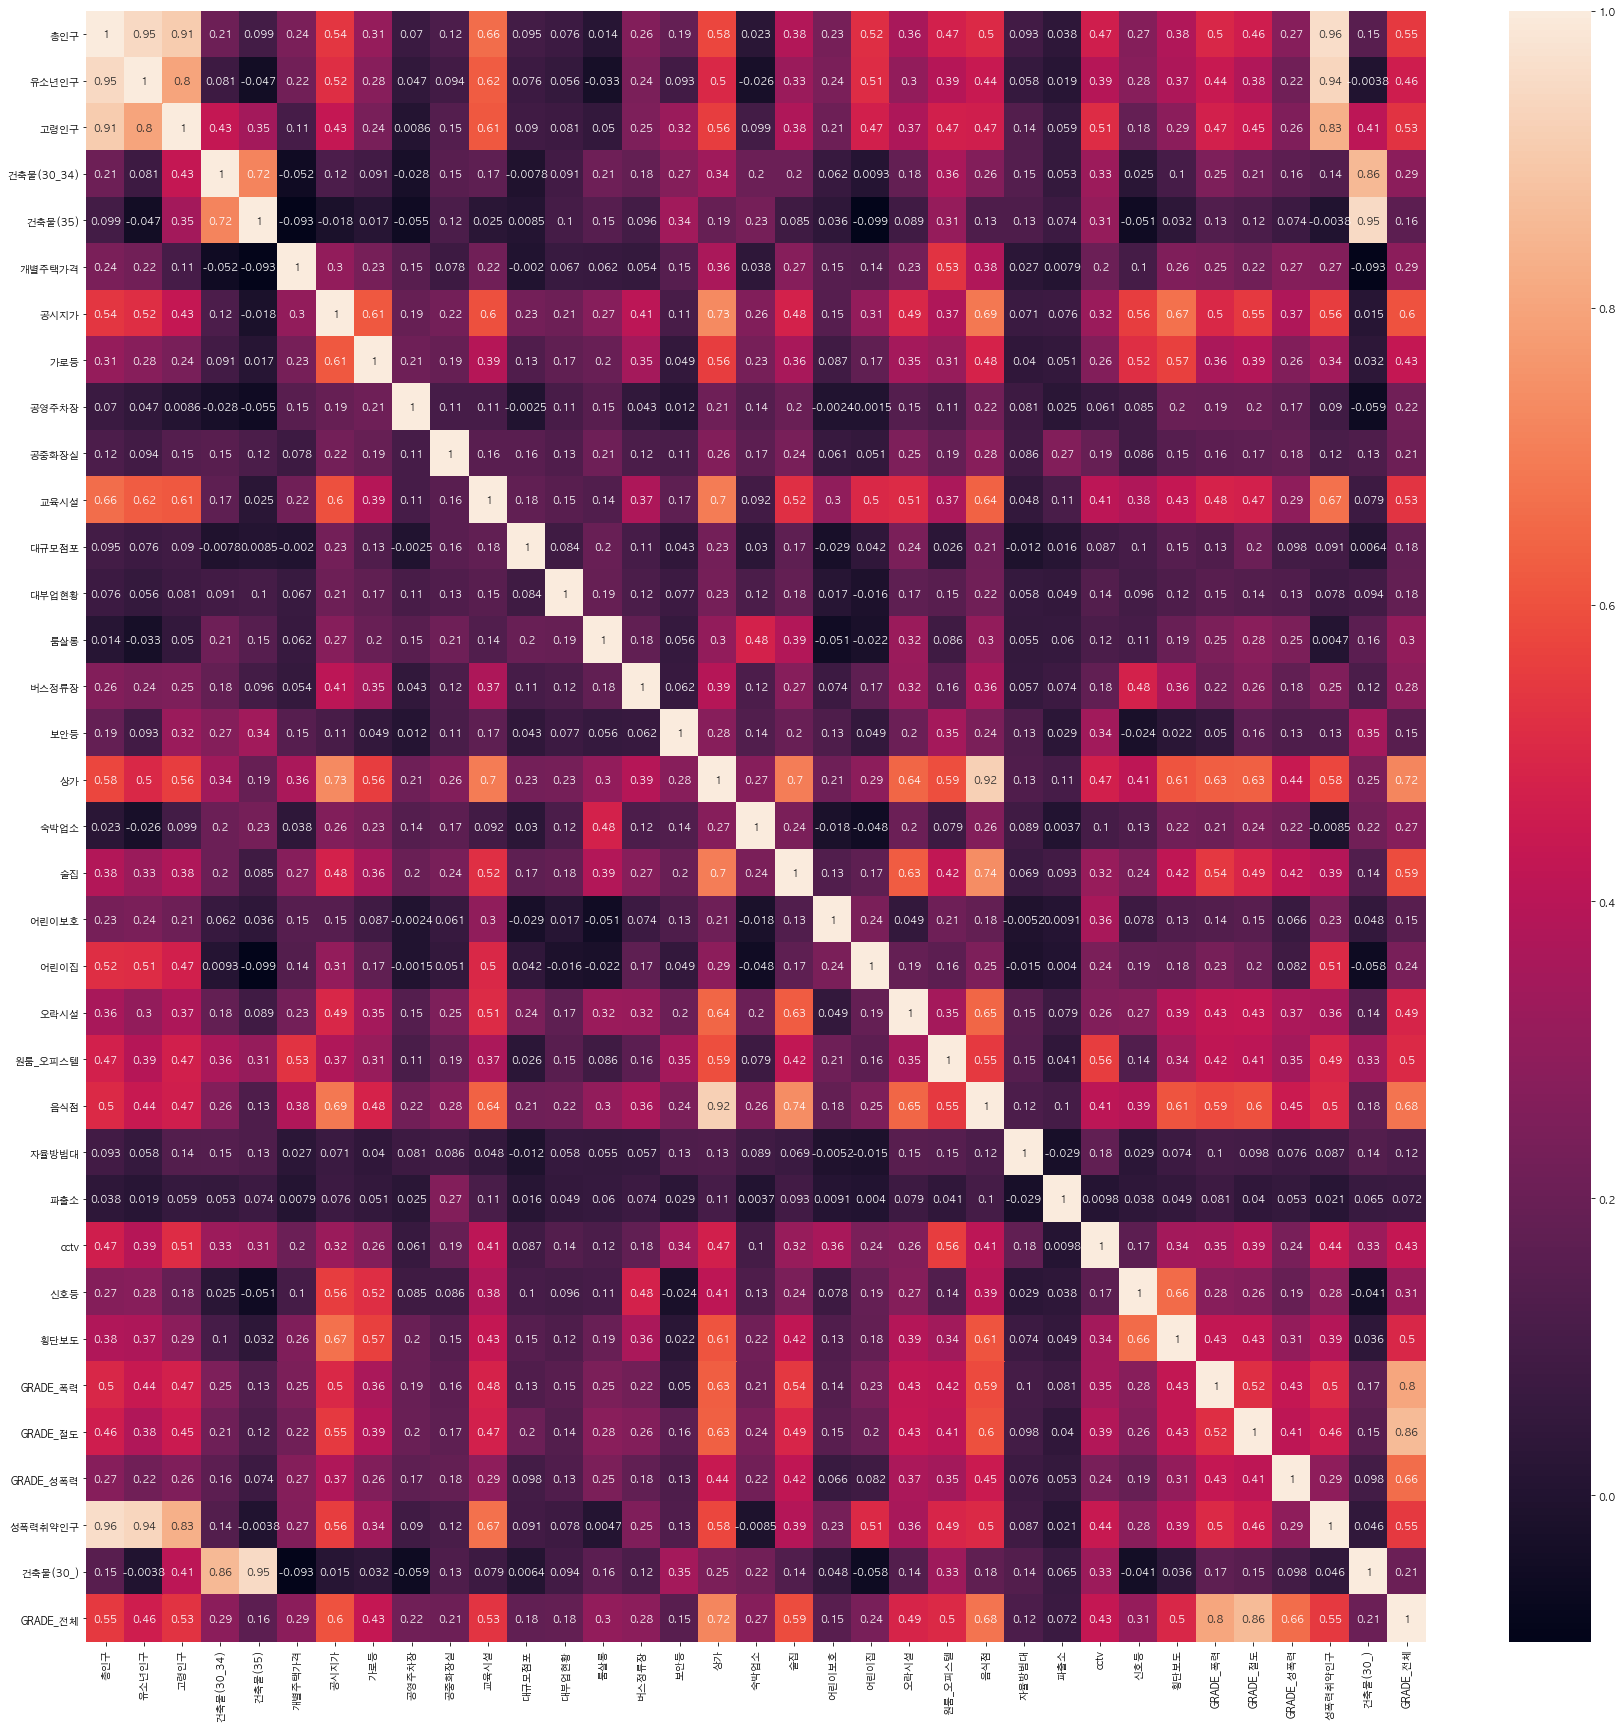

In [54]:
plt.figure(figsize=(30, 30))
sns.heatmap(new_grid.corr(method = 'spearman'), annot=True)
plt.show()

### 전체 변수 간 상관관계 
 - 인구 사회학적 변수는 변수간 상관관계가 크며, 이는 다중공선성 제거를 위해 변수를 선택할 필요가 있다. 또한, 대부분 범죄 등급과도 큰 상관관계를 보이고 있다. 

#### 종속변수 (3대범죄)를 기반으로 한 상관계수 확인
 
- `인구` : 총인구 (0.69),성폭력취약인구(0.72), 유소년인구(0.69), 고령인구(0.68)
- `토지` : 30년 이상35년 미만 건축물(0.4), 35년 이상건축물(0.28), 30년 이상 건축물 (0.33),개별주택가격 (0.38), 공시지가(0.68)
- `시설물` : 가로등(0.54), 공영주차장(0.22), 공중화장실(0.28), 교육시설(0.64), 대규모점포(0.18), 대부업체현황(0.22), 룸살롱(0.26), 버스정류장(0.4), 보안등(0.26), 상가(0.76), 숙박업소(0.24), 술집(0.57), 어린이보호구역(0.23), 어린이집(0.39), 오락시설(0.52), 원룸_오피스텔(0.61), 음식점(0.71), 자율방범대(0.17), 파출소(0.12), cctv(0.56), 신호등(0.47), 횡단보도(0.65)

In [55]:
new_grid.shape

(1029, 37)

In [56]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)', 'GRADE_전체'],
      dtype='object')

In [57]:
def hist(x) : 
    plt.hist(new_grid[x])
    plt.xlabel(x)

In [58]:
def scatter(x) : 
    plt.plot(x,'GRADE_전체', linestyle='none', marker='o', markersize=3, color='blue', data = new_grid)
    plt.xlabel(x)


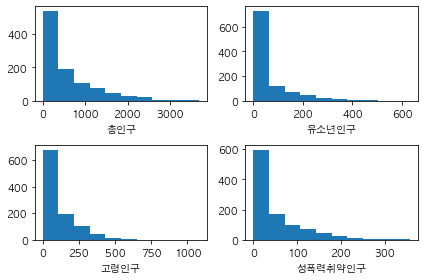

In [59]:
plt.subplot(221)
hist('총인구')

plt.subplot(222)
hist('유소년인구')

plt.subplot(223)
hist('고령인구')

plt.subplot(224)
hist('성폭력취약인구')

plt.tight_layout()
plt.show()

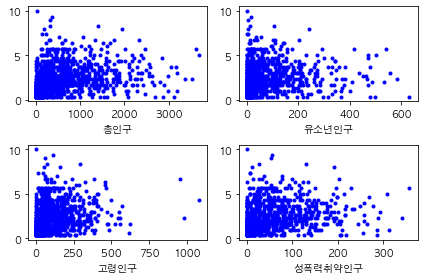

In [60]:
plt.subplot(221)
scatter('총인구')

plt.subplot(222)
scatter('유소년인구')

plt.subplot(223)
scatter('고령인구')

plt.subplot(224)
scatter('성폭력취약인구')

plt.tight_layout()
plt.show()

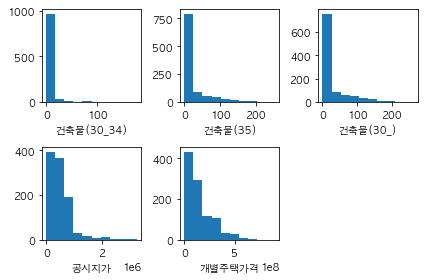

In [61]:
plt.subplot(231)
hist('건축물(30_34)')

plt.subplot(232)
hist('건축물(35)')

plt.subplot(233)
hist('건축물(30_)')

plt.subplot(234)
hist('공시지가')

plt.subplot(235)
hist('개별주택가격')

plt.tight_layout()
plt.show()

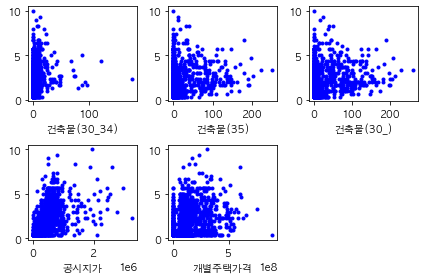

In [62]:
plt.subplot(231)
scatter('건축물(30_34)')

plt.subplot(232)
scatter('건축물(35)')

plt.subplot(233)
scatter('건축물(30_)')

plt.subplot(234)
scatter('공시지가')

plt.subplot(235)
scatter('개별주택가격')

plt.tight_layout()
plt.show()

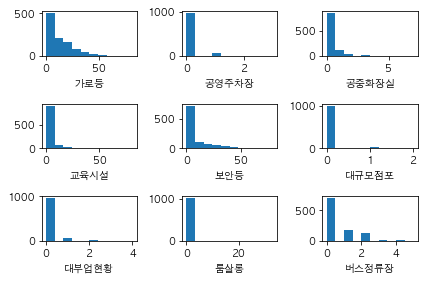

In [63]:
plt.subplot(331)
hist('가로등')

plt.subplot(332)
hist('공영주차장')

plt.subplot(333)
hist('공중화장실')

plt.subplot(334)
hist('교육시설')

plt.subplot(335)
hist('보안등')

plt.subplot(336)
hist('대규모점포')

plt.subplot(337)
hist('대부업현황')

plt.subplot(338)
hist('룸살롱')

plt.subplot(339)
hist('버스정류장')

plt.tight_layout()
plt.show()

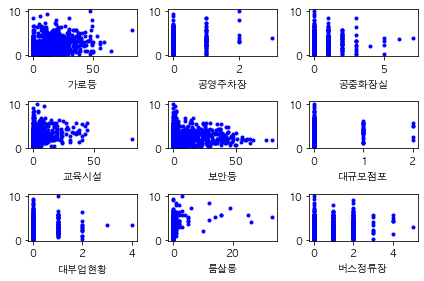

In [64]:
plt.subplot(331)
scatter('가로등')

plt.subplot(332)
scatter('공영주차장')

plt.subplot(333)
scatter('공중화장실')

plt.subplot(334)
scatter('교육시설')

plt.subplot(335)
scatter('보안등')

plt.subplot(336)
scatter('대규모점포')

plt.subplot(337)
scatter('대부업현황')

plt.subplot(338)
scatter('룸살롱')

plt.subplot(339)
scatter('버스정류장')

plt.tight_layout()
plt.show()

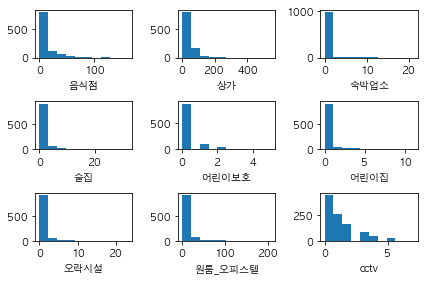

In [65]:
plt.subplot(331)
hist('음식점')

plt.subplot(332)
hist('상가')

plt.subplot(333)
hist('숙박업소')

plt.subplot(334)
hist('술집')

plt.subplot(335)
hist('어린이보호')

plt.subplot(336)
hist('어린이집')

plt.subplot(337)
hist('오락시설')

plt.subplot(338)
hist('원룸_오피스텔')

plt.subplot(339)
hist('cctv')

plt.tight_layout()
plt.show()

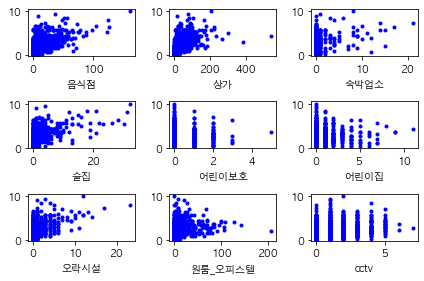

In [66]:
plt.subplot(331)
scatter('음식점')

plt.subplot(332)
scatter('상가')

plt.subplot(333)
scatter('숙박업소')

plt.subplot(334)
scatter('술집')

plt.subplot(335)
scatter('어린이보호')

plt.subplot(336)
scatter('어린이집')

plt.subplot(337)
scatter('오락시설')

plt.subplot(338)
scatter('원룸_오피스텔')

plt.subplot(339)
scatter('cctv')

plt.tight_layout()
plt.show()

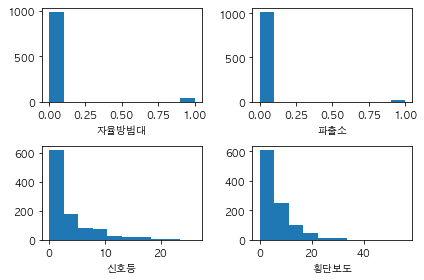

In [67]:
plt.subplot(221)
hist('자율방범대')

plt.subplot(222)
hist('파출소')

plt.subplot(223)
hist('신호등')

plt.subplot(224)
hist('횡단보도')

plt.tight_layout()
plt.show()

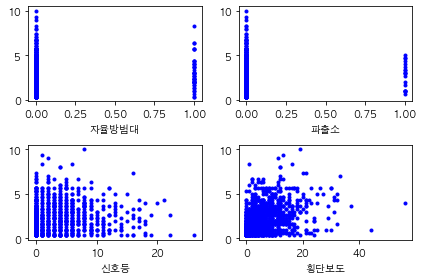

In [68]:
plt.subplot(221)
scatter('자율방범대')

plt.subplot(222)
scatter('파출소')

plt.subplot(223)
scatter('신호등')

plt.subplot(224)
scatter('횡단보도')

plt.tight_layout()
plt.show()

In [69]:
new_grid = new_grid[new_grid['개별주택가격']<4000000000]

#### 행정동면적, ID, 행정동 코드는 분석에서 제외
#### 최대값이 50미만인 변수는 MinMaxScale
#### 최대값이 50이상인 변수는 StandardScale

In [156]:
standard_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
standard_feats.remove('GRADE_전체')
standard_feats.remove('공영주차장')
standard_feats.remove('공중화장실')
standard_feats.remove('대규모점포')
standard_feats.remove('대부업현황')
standard_feats.remove('룸살롱')
standard_feats.remove('버스정류장')
standard_feats.remove('숙박업소')
standard_feats.remove('술집')
standard_feats.remove('어린이집')
standard_feats.remove('오락시설')
standard_feats.remove('cctv')
standard_feats.remove('자율방범대')
standard_feats.remove('파출소')


min_max_feats = list(new_grid.loc[:,['공영주차장','공중화장실','대규모점포','대부업현황','룸살롱','버스정류장','숙박업소','술집','어린이집','오락시설','cctv']].columns)
print("Number of Minmax features :", len(min_max_feats))
print("Number of Standard features: ", len(standard_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Minmax features : 11
Number of Standard features:  22
Number of Categorical features:  2


In [157]:
scaler = StandardScaler()
new_grid[standard_feats] = scaler.fit_transform(new_grid[standard_feats])

In [158]:
scaler = MinMaxScaler()
new_grid[min_max_feats] = scaler.fit_transform(new_grid[min_max_feats])

### 변수 선택을 위한 분산분석 실시

In [73]:
new_grid.loc[(new_grid['GRADE_전체']==0),'범죄빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_전체']>0)&(new_grid['GRADE_전체']<4),'범죄빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_전체']>=4)&(new_grid['GRADE_전체']<8),'범죄빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_전체']>=8)&(new_grid['GRADE_전체']<11),'범죄빈도_4'] = 3

In [74]:
group_1 = new_grid[new_grid['범죄빈도_4'] == 0]
group_2 = new_grid[new_grid['범죄빈도_4'] == 1]
group_3 = new_grid[new_grid['범죄빈도_4'] == 2]
group_4 = new_grid[new_grid['범죄빈도_4'] == 3]

In [75]:
def anova(x):
    F_statistic, pVal = stats.f_oneway(group_1[x], group_2[x], group_3[x], group_4[x])

    print(x,' 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
    if pVal < 0.05:
        print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [76]:
anova('총인구')
anova('유소년인구')
anova('고령인구')
anova('성폭력취약인구')
anova('건축물(30_34)')
anova('건축물(35)')
anova('건축물(30_)')
anova('개별주택가격')
anova('공시지가')
anova('가로등')
anova('보안등')
anova('공중화장실')
anova('버스정류장')
anova('공영주차장')
anova('교육시설')
anova('대규모점포')
anova('대부업현황')
anova('룸살롱')
anova('버스정류장')
anova('보안등')
anova('상가')
anova('숙박업소')
anova('술집')
anova('어린이보호')
anova('어린이집')
anova('오락시설')
anova('원룸_오피스텔')
anova('음식점')
anova('자율방범대')
anova('파출소')
anova('cctv')
anova('신호등')
anova('횡단보도')

총인구  데이터의 일원분산분석 결과 : F=nan, p=nan
유소년인구  데이터의 일원분산분석 결과 : F=nan, p=nan
고령인구  데이터의 일원분산분석 결과 : F=nan, p=nan
성폭력취약인구  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(30_34)  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(35)  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(30_)  데이터의 일원분산분석 결과 : F=nan, p=nan
개별주택가격  데이터의 일원분산분석 결과 : F=nan, p=nan
공시지가  데이터의 일원분산분석 결과 : F=nan, p=nan
가로등  데이터의 일원분산분석 결과 : F=nan, p=nan
보안등  데이터의 일원분산분석 결과 : F=nan, p=nan
공중화장실  데이터의 일원분산분석 결과 : F=nan, p=nan
버스정류장  데이터의 일원분산분석 결과 : F=nan, p=nan
공영주차장  데이터의 일원분산분석 결과 : F=nan, p=nan
교육시설  데이터의 일원분산분석 결과 : F=nan, p=nan
대규모점포  데이터의 일원분산분석 결과 : F=nan, p=nan
대부업현황  데이터의 일원분산분석 결과 : F=nan, p=nan
룸살롱  데이터의 일원분산분석 결과 : F=nan, p=nan
버스정류장  데이터의 일원분산분석 결과 : F=nan, p=nan
보안등  데이터의 일원분산분석 결과 : F=nan, p=nan
상가  데이터의 일원분산분석 결과 : F=nan, p=nan
숙박업소  데이터의 일원분산분석 결과 : F=nan, p=nan
술집  데이터의 일원분산분석 결과 : F=nan, p=nan
어린이보호  데이터의 일원분산분석 결과 : F=nan, p=nan
어린이집  데이터의 일원분산분석 결과 : F=nan, p=nan
오락시설  데이터의 일원분산분석 결과 : F=nan, p=nan
원룸_오피스텔  데이터의 일원분산분석 결과 : F=nan, p=nan
음식점  데이터

In [77]:
def compare(x,y):
    comp = MultiComparison(new_grid[x], new_grid[y])
    result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
    return result[0]

In [78]:
compare('총인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.9509,0.0,0.0,True
1.0,3.0,-0.4746,0.6352,1.0,False
2.0,3.0,0.8312,0.4071,1.0,False


In [79]:
compare('유소년인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-3.3846,0.0007,0.0022,True
1.0,3.0,0.1078,0.9142,1.0,False
2.0,3.0,0.8209,0.413,1.0,False


In [80]:
compare('고령인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-6.044,0.0,0.0,True
1.0,3.0,-0.3091,0.7573,1.0,False
2.0,3.0,0.8732,0.3839,1.0,False


In [81]:
compare('성폭력취약인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.8221,0.0,0.0,True
1.0,3.0,-1.061,0.289,0.867,False
2.0,3.0,0.2703,0.7873,1.0,False


In [82]:
compare('건축물(30_34)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.7289,0.0065,0.0194,True
1.0,3.0,-0.7968,0.4258,1.0,False
2.0,3.0,-0.1068,0.9151,1.0,False


In [83]:
compare('건축물(35)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-1.8656,0.0624,0.1872,False
1.0,3.0,0.2044,0.8381,1.0,False
2.0,3.0,0.5822,0.5612,1.0,False


In [84]:
compare('건축물(30_)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.4388,0.0149,0.0447,True
1.0,3.0,-0.0409,0.9674,1.0,False
2.0,3.0,0.4757,0.6349,1.0,False


In [85]:
compare('개별주택가격','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.9584,0.0,0.0,True
1.0,3.0,-2.2058,0.0277,0.083,False
2.0,3.0,-1.0761,0.2835,0.8505,False


In [86]:
compare('공시지가','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-10.152,0.0,0.0,True
1.0,3.0,-6.4319,0.0,0.0,True
2.0,3.0,-3.0206,0.0029,0.0088,True


In [87]:
compare('공영주차장','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.705,0.0,0.0,True
1.0,3.0,-8.7483,0.0,0.0,True
2.0,3.0,-3.7722,0.0002,0.0007,True


In [88]:
compare('공중화장실','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.5086,0.0,0.0,True
1.0,3.0,-1.4346,0.1517,0.4552,False
2.0,3.0,-0.1997,0.842,1.0,False


In [89]:
compare('교육시설','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-7.1491,0.0,0.0,True
1.0,3.0,-0.062,0.9506,1.0,False
2.0,3.0,1.1431,0.2547,0.7642,False


In [90]:
compare('대규모점포','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.9728,0.0,0.0,True
1.0,3.0,0.347,0.7287,1.0,False
2.0,3.0,0.8791,0.3807,1.0,False


In [91]:
compare('대부업현황','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-1.9084,0.0566,0.1699,False
1.0,3.0,-0.5442,0.5864,1.0,False
2.0,3.0,-0.0837,0.9334,1.0,False


In [92]:
compare('룸살롱','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.3727,0.0,0.0,True
1.0,3.0,-12.7413,0.0,0.0,True
2.0,3.0,-0.6955,0.4878,1.0,False


In [93]:
compare('버스정류장','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-6.624,0.0,0.0,True
1.0,3.0,-1.0646,0.2874,0.8621,False
2.0,3.0,0.3982,0.691,1.0,False


In [94]:
compare('보안등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,0.5013,0.6163,1.0,False
1.0,3.0,1.4114,0.1585,0.4754,False
2.0,3.0,1.497,0.1364,0.4091,False


In [95]:
compare('상가','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-14.7369,0.0,0.0,True
1.0,3.0,-6.2739,0.0,0.0,True
2.0,3.0,-1.1937,0.2344,0.7032,False


In [96]:
compare('숙박업소','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.6126,0.0,0.0,True
1.0,3.0,-7.3728,0.0,0.0,True
2.0,3.0,-1.1876,0.2368,0.7103,False


In [97]:
compare('술집','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-14.7103,0.0,0.0,True
1.0,3.0,-19.8337,0.0,0.0,True
2.0,3.0,-5.4135,0.0,0.0,True


In [98]:
compare('어린이보호','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.0105,0.0446,0.1339,False
1.0,3.0,0.1911,0.8485,1.0,False
2.0,3.0,0.5863,0.5585,1.0,False


In [99]:
compare('어린이집','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.5038,0.0124,0.0373,True
1.0,3.0,0.4985,0.6183,1.0,False
2.0,3.0,0.8276,0.4091,1.0,False


In [100]:
compare('오락시설','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-13.7012,0.0,0.0,True
1.0,3.0,-13.3959,0.0,0.0,True
2.0,3.0,-3.4776,0.0007,0.002,True


In [101]:
compare('원룸_오피스텔','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.6089,0.0,0.0,True
1.0,3.0,-0.1954,0.8452,1.0,False
2.0,3.0,0.723,0.4707,1.0,False


In [102]:
compare('음식점','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-17.2197,0.0,0.0,True
1.0,3.0,-13.0812,0.0,0.0,True
2.0,3.0,-3.9426,0.0001,0.0004,True


In [103]:
compare('자율방범대','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-1.9076,0.0567,0.1702,False
1.0,3.0,-1.431,0.1528,0.4584,False
2.0,3.0,-0.6937,0.4889,1.0,False


In [104]:
compare('파출소','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-1.3991,0.1621,0.4863,False
1.0,3.0,0.3382,0.7353,1.0,False
2.0,3.0,0.4832,0.6296,1.0,False


In [105]:
compare('cctv','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-6.22,0.0,0.0,True
1.0,3.0,-0.7919,0.4287,1.0,False
2.0,3.0,0.5921,0.5547,1.0,False


In [106]:
compare('신호등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-3.4421,0.0006,0.0018,True
1.0,3.0,-0.5538,0.5798,1.0,False
2.0,3.0,0.2395,0.8111,1.0,False


In [107]:
compare('횡단보도','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-10.1056,0.0,0.0,True
1.0,3.0,-3.1051,0.002,0.0059,True
2.0,3.0,-0.4171,0.6772,1.0,False


In [108]:
compare('가로등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-6.9664,0.0,0.0,True
1.0,3.0,-2.6747,0.0076,0.0229,True
2.0,3.0,-0.9605,0.3383,1.0,False


#### 선택한 변수 :  
'공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔','개별주택가격','건축물(35)',cctv
                                   

In [114]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)', 'GRADE_전체', '범죄빈도_4', '유흥시설'],
      dtype='object')

In [161]:
new_grid['유흥시설'] = new_grid['음식점']+new_grid['술집']+new_grid['오락시설']

In [162]:
feature_list = list(new_grid.loc[:,['유흥시설', '총인구', 'cctv']].columns)

feature = new_grid[feature_list]
target = new_grid[['GRADE_전체']]

### 다중공선성 확인

In [163]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,1.068881,유흥시설
1,1.051846,총인구
2,1.070636,cctv


### 다중공선성 확인 결과 분석에 영향을 미칠만한 공선성은 없는 것으로 보임

In [164]:
len(new_grid)

1029

In [165]:
407, 1630

(407, 1630)

#### 로지스틱, 데이터 100% 

In [170]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)

feature = new_grid[feature_list]
target = new_grid[['GRADE_전체']]

In [171]:
from sklearn.linear_model import LinearRegression

In [172]:
regr = RandomForestRegressor(max_depth=4, random_state=531,
                          n_estimators=150)
regr.fit(feature, target)
prediction = regr.predict(feature)
print(r2_score(target, prediction))
featureImportance = regr.feature_importances_

0.6131911920682913


In [173]:
regr = LinearRegression()
regr.fit(feature, target)
prediction = regr.predict(feature)
print(r2_score(target, prediction))


0.5373448575859199


In [119]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.8639455782312925


array([[846,  23,   0],
       [111,  42,   0],
       [  2,   4,   1]])

### 로지스틱 다중분류 데이터 70%

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size=0.3, stratify=target, random_state=123456)

In [111]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=X_train, y=y_train) # 학습수행 
y_pred = model.predict(X = X_test)
acc=accuracy_score(y_test,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred) 
con_mat 

accuracy = 0.760655737704918


array([[193,  20,   1],
       [ 48,  37,   0],
       [  1,   3,   2]])

### 렌포 데이터 70%

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123)

In [86]:
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=123)

In [87]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.745
Mean accuracy score: 0.767


array([[193,  21,   0],
       [ 45,  40,   0],
       [  2,   3,   1]])

In [88]:
np.array(rf.feature_importances_)

array([0.14598531, 0.02595786, 0.07649394, 0.04065624, 0.13811873,
       0.00777391, 0.0732473 , 0.06612819, 0.05963709, 0.12540205,
       0.06476596, 0.07911881, 0.05653647, 0.04017814])

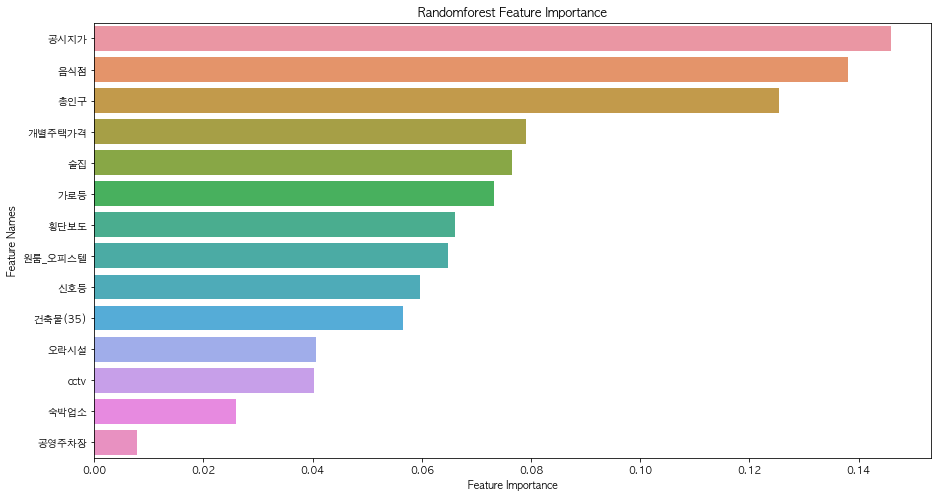

In [89]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(15,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')



plot_feature_importance(rf.feature_importances_,feature_list,'Randomforest')

In [90]:
feature_list

['공시지가',
 '숙박업소',
 '술집',
 '오락시설',
 '음식점',
 '공영주차장',
 '가로등',
 '횡단보도',
 '신호등',
 '총인구',
 '원룸_오피스텔',
 '개별주택가격',
 '건축물(35)',
 'cctv']

In [91]:
rf.feature_importances_

array([0.14598531, 0.02595786, 0.07649394, 0.04065624, 0.13811873,
       0.00777391, 0.0732473 , 0.06612819, 0.05963709, 0.12540205,
       0.06476596, 0.07911881, 0.05653647, 0.04017814])

### GBM

In [92]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer



cancer = load_breast_cancer()

In [93]:
gbc = GradientBoostingClassifier(random_state=0) # 기본값: max_depth=3, learning_rate=0.1

gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [94]:
predicted = gbc.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.745
Mean accuracy score: 0.748


array([[189,  24,   1],
       [ 42,  38,   5],
       [  2,   3,   1]])

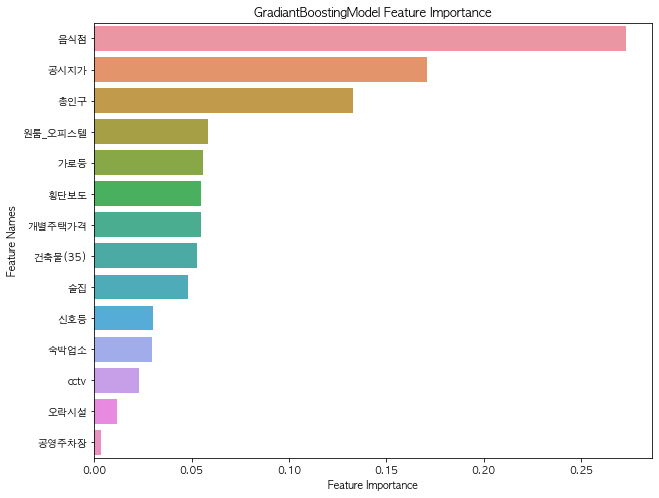

In [95]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')



plot_feature_importance(gbc.feature_importances_,feature_list,'GradiantBoostingModel')

In [96]:
from sklearn.neighbors import KNeighborsClassifier

In [97]:
KNN = KNeighborsClassifier(n_neighbors = 4)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [98]:
predicted = KNN.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.745
Mean accuracy score: 0.725


array([[196,  18,   0],
       [ 60,  25,   0],
       [  2,   4,   0]])

### k-fold 교차분석

#### 로지스틱

In [99]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)

feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [100]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.74630542, 검증 Accuracy = 0.88177340
학습 Accuracy = 0.76847291, 검증 Accuracy = 0.81773399
학습 Accuracy = 0.78940887, 검증 Accuracy = 0.69458128
학습 Accuracy = 0.80541872, 검증 Accuracy = 0.67487685
학습 Accuracy = 0.77832512, 검증 Accuracy = 0.73399015
[0.8817734  0.81773399 0.69458128 0.67487685 0.73399015]


0.7605911330049261

#### 랜포

In [101]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model =  RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 1.00000000, 검증 Accuracy = 0.88177340
학습 Accuracy = 1.00000000, 검증 Accuracy = 0.75862069
학습 Accuracy = 1.00000000, 검증 Accuracy = 0.67980296
학습 Accuracy = 1.00000000, 검증 Accuracy = 0.66502463
학습 Accuracy = 1.00000000, 검증 Accuracy = 0.71921182
[0.8817734  0.75862069 0.67980296 0.66502463 0.71921182]


0.7408866995073892

#### GBM

In [112]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model =  GradientBoostingClassifier(random_state=0)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.93349754, 검증 Accuracy = 0.88177340
학습 Accuracy = 0.95935961, 검증 Accuracy = 0.79310345
학습 Accuracy = 0.95320197, 검증 Accuracy = 0.68472906
학습 Accuracy = 0.96182266, 검증 Accuracy = 0.68472906
학습 Accuracy = 0.95197044, 검증 Accuracy = 0.69458128
[0.8817734  0.79310345 0.68472906 0.68472906 0.69458128]


0.7477832512315271

### KNN

In [113]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = KNeighborsClassifier(n_neighbors = 4)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.77832512, 검증 Accuracy = 0.90147783
학습 Accuracy = 0.80911330, 검증 Accuracy = 0.75369458
학습 Accuracy = 0.80788177, 검증 Accuracy = 0.67487685
학습 Accuracy = 0.82512315, 검증 Accuracy = 0.62068966
학습 Accuracy = 0.81403941, 검증 Accuracy = 0.65517241
[0.90147783 0.75369458 0.67487685 0.62068966 0.65517241]


0.7211822660098521